# Dev notebook for updates

`No development at the moment`

In [17]:
import numpy as np
from dmrg.MPS import MPS 
from dmrg.MPO import MPO_TFI
from dmrg.cont import CONT
from dmrg.dmrg import dmrg
# from dmrg.obs import observables

import matplotlib.pyplot as plt

### Class 

### Test

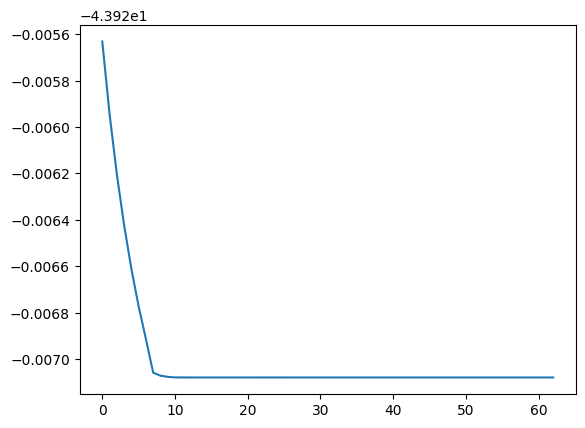

In [45]:
L = 20
mps = MPS(L,d=2)
h = MPO_TFI(1,1,pol='tot')
cont = CONT(mps,h) 
sys = dmrg(cont,chi=2)
obs = observables(mps)
mps.random()
cont.random()

# create folder out if not present
path_out = 'OUT/'
if os.path.isdir(path_out):
    shutil.rmtree(path_out)
os.mkdir(path_out)


sys.chi = 100
EE = []
EE_pre = []
k = 0 


for site,dir in mps.first_sweep():
    # print(site)
    En,_ = sys.step2sites(site,dir=dir)
    # EE.append(En)

for site,dir in mps.sweep():
    En,_ = sys.step2sites(site,dir=dir)
    EE.append(En)

for site,dir in mps.sweep():
    En,_ = sys.step2sites(site,dir=dir)
    EE.append(En)

# Final sweep to store observables
for site,dir in mps.right_sweep():
    _,S = sys.step2sites(site,dir=dir,stage='Final')

    # Store local magnetization
    if site == 2:
        o1,o2 = obs.bound_left(site-1,h.Z)
        with open(path_out + 'ZZ.txt','a') as fz:
            fz.write(f'{site} {o1.real} \n')
            fz.write(f'{site} {o2.real} \n')

    with open(path_out + 'ZZ.txt','a') as fz:
            fz.write(f'{site} {obs.single_site(site,h.Z).real} \n')

    if site == L-3:
        o1,o2 = obs.bound_right(site+1,h.Z)
        with open(path_out + 'ZZ.txt','a') as fz:
            fz.write(f'{site} {o1.real} \n')
            fz.write(f'{site} {o2.real} \n')

    # Store entanglement entropy
    with open(path_out + 'S.txt','a') as fz:
            fz.write(f'{site} {site+1} {S} \n')

    # Store all two point correlations from site

    obs.all_corr(path_out + 'ZZstring.txt',site,string=h.Z,obs1=h.Z)
    obs.all_corr(path_out + 'ZZcorr.txt',site,string=h.Id,obs1=h.Z)

plt.plot(EE[1:])

In [ ]:
from itertools import product
dim = [4,2,2]
Id4 = np.identity(4)
res = np.zeros((2,2,4))
ranges = [range(d) for d in dim]
for i in product(*ranges):
    res[i[0],i[1],i[2]] =Id4[i[0]i[1]i[2]]

In [ ]:
d=4
a = np.reshape(np.identity(d**2)[:,:d],(d,d,d))
np.tensordot(a,a,((0,1),(0,1)))